In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Read in data from sql_queries
data = pd.read_csv("data/sql_data_filtered_censored.csv")

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   origin        2111 non-null   object
 1   type          2111 non-null   object
 2   start_date    2111 non-null   object
 3   end_date      2111 non-null   object
 4   author_count  2111 non-null   int64 
 5   rev_count     2111 non-null   int64 
 6   censored      2111 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 115.6+ KB


In [28]:
data.author_count.sum(), data.rev_count.sum()

(141876, 4315279)

In [29]:
data.head()

,origin,type,start_date,end_date,author_count,rev_count,censored
0,deb://Debian/packages/accerciser,deb,2012-04-18 17:06:21,2019-10-11 00:10:47,4,8,1
1,deb://Debian/packages/angrydd,deb,2008-10-19 12:19:40,2019-08-09 18:47:59,4,5,0
2,deb://Debian/packages/cedar-backup3,deb,2016-09-05 18:27:20,2019-08-25 14:20:15,1,7,1
3,deb://Debian/packages/expeyes,deb,2012-04-18 17:22:57,2019-11-26 19:11:26,2,22,1
4,deb://Debian/packages/fonttools,deb,2009-11-14 14:58:53,2019-12-22 22:26:30,7,11,1


In [30]:
## Censoring the data
# censored_date = pd.to_datetime('2019-12-31').tz_localize('UTC')
# data['end_date']= pd.to_datetime(data['end_date'], utc=True)
# data['start_date']= pd.to_datetime(data['start_date'], utc=True)
# data['censored'] = (data['end_date'] > censored_date)#.astype(int)
# data.censored.value_counts()

In [31]:
data.censored.value_counts()

censored
1    1450
0     661
Name: count, dtype: int64

## Calculate the Duration in Days and Months for each Project

In [32]:
data['end_date']= pd.to_datetime(data['end_date'], utc=True)
data['start_date']= pd.to_datetime(data['start_date'], utc=True)

In [33]:
data['duration_days'] = (data['end_date'] - data['start_date']).dt.days + 1

In [34]:
from dateutil.relativedelta import relativedelta

# Assuming data['start_date'] and data['end_date'] are datetime objects
data['duration_months'] = data.apply(lambda row: relativedelta(row['end_date'], row['start_date']).years * 12 + relativedelta(row['end_date'], row['start_date']).months + 1, axis=1)

In [35]:
data.head()

,origin,type,start_date,end_date,author_count,rev_count,censored,duration_days,duration_months
0,deb://Debian/packages/accerciser,deb,2012-04-18 17:06:21+00:00,2019-10-11 00:10:47+00:00,4,8,1,2732,90
1,deb://Debian/packages/angrydd,deb,2008-10-19 12:19:40+00:00,2019-08-09 18:47:59+00:00,4,5,0,3947,130
2,deb://Debian/packages/cedar-backup3,deb,2016-09-05 18:27:20+00:00,2019-08-25 14:20:15+00:00,1,7,1,1084,36
3,deb://Debian/packages/expeyes,deb,2012-04-18 17:22:57+00:00,2019-11-26 19:11:26+00:00,2,22,1,2779,92
4,deb://Debian/packages/fonttools,deb,2009-11-14 14:58:53+00:00,2019-12-22 22:26:30+00:00,7,11,1,3691,122


In [36]:
data.rev_count.sum()



4315279

## Create Revision Frequency Columns

In [37]:
# Create Revision Frequency
data['rev_freq'] = data['rev_count'] / data['duration_days']
# Create column for high frequency vs low frequency
data['high_rev_freq'] = data['rev_freq'] > 1

data['high_rev_freq'].value_counts()

high_rev_freq
False    1887
True      224
Name: count, dtype: int64

## Determine Whether Projects are Hosted on Multiple Repositories

In [38]:
## Extract Project Names from URLs
# This makes assumptions about url structure and project naming
projects = []
for elem in data['origin'].str.findall("(.+)/(.+)(/*$)"):
    projects.append(elem[0][1].replace("/",""))
data['project'] = projects


In [39]:
# These are mistakes, the project and host_type should uniquely identify the repos, but git projects
# can have duplicated names, so these projects are not actually hosted on multiple repos
temp = data.groupby(['project', 'type']).count()['censored']
non_multi_repo_projects = [x for (x,y) in temp[temp > 1].index]
non_multi_repo_projects

['Python-100-Days', 'dataset', 'tqdm', 'tutorials']

In [40]:
temp = data.groupby(['project']).count()['censored']
temp[temp == 1] = 0
temp[temp > 1] = 1
# fix errors
temp[non_multi_repo_projects] = 0

multi_repo = []
for i, row in data.iterrows():
    multi_repo.append(temp[row['project']])

data['multi_repo'] = multi_repo
data['multi_repo'] = data['multi_repo'].astype(bool)
data['multi_repo'].value_counts()

multi_repo
False    1958
True      153
Name: count, dtype: int64

## High Author Count

In [41]:
data['high_author_count'] = data['author_count'] > 20
data['high_author_count'].value_counts()

high_author_count
False    1717
True      394
Name: count, dtype: int64

## Save to CSVs

In [42]:
data.to_csv("data/all_fields.csv", index=False)

In [43]:
refined = data.drop(['origin', 'author_count', 'start_date', 'end_date', 'rev_count', 'project', 'duration_days', 'rev_freq'], axis='columns')
refined.to_csv('data/necessary_fields.csv', index=False)

# Create Figure 1 (Ordered Timeline of Projects)

In [44]:
from dateutil.relativedelta import relativedelta
import pandas as pd

graph_data = data.copy()
# Assuming 'data' is your DataFrame containing project information
beginning_month = pd.to_datetime('2005-01-01 00:00:00-07:00', utc=True)

# Calculate start month
graph_data['start_month'] = graph_data.apply(lambda row: (row['start_date'].year - beginning_month.year) * 12 + relativedelta(row['start_date'], beginning_month).months, axis=1)

# Calculate end month
graph_data['end_month'] = graph_data.apply(lambda row: (row['end_date'].year - beginning_month.year) * 12 + relativedelta(row['end_date'], beginning_month).months, axis=1)

# Sort the DataFrame by duration_months
graph_data = graph_data.sort_values(by='duration_months')


In [45]:
graph_data.head()

,origin,type,start_date,end_date,author_count,rev_count,censored,duration_days,duration_months,rev_freq,high_rev_freq,project,multi_repo,high_author_count,start_month,end_month
765,https://pypi.org/project/sarif-om/,pypi,2019-10-01 20:53:03+00:00,2019-10-05 20:11:23+00:00,1,7,0,4,1,1.750000,True,sarif-om,False,False,177,177
108,https://pypi.org/project/jschema-to-python/,pypi,2019-10-01 20:42:32+00:00,2019-10-05 20:02:39+00:00,1,6,0,4,1,1.500000,True,jschema-to-python,False,False,177,177
1893,deb://Debian/packages/python-pysnmp4-apps,deb,2012-05-21 11:19:23+00:00,2012-05-21 11:19:23+00:00,1,1,1,1,1,1.000000,False,python-pysnmp4-apps,False,False,88,88
105,https://pypi.org/project/google-cloud-secret-m...,pypi,2019-12-20 15:05:01+00:00,2019-12-20 15:05:01+00:00,1,1,1,1,1,1.000000,False,google-cloud-secret-manager,False,False,179,179
416,https://github.com/WZMIAOMIAO/deep-learning-fo...,git,2019-12-10 06:44:14+00:00,2019-12-23 09:38:01+00:00,2,17,1,14,1,1.214286,True,deep-learning-for-image-processing,False,False,179,179


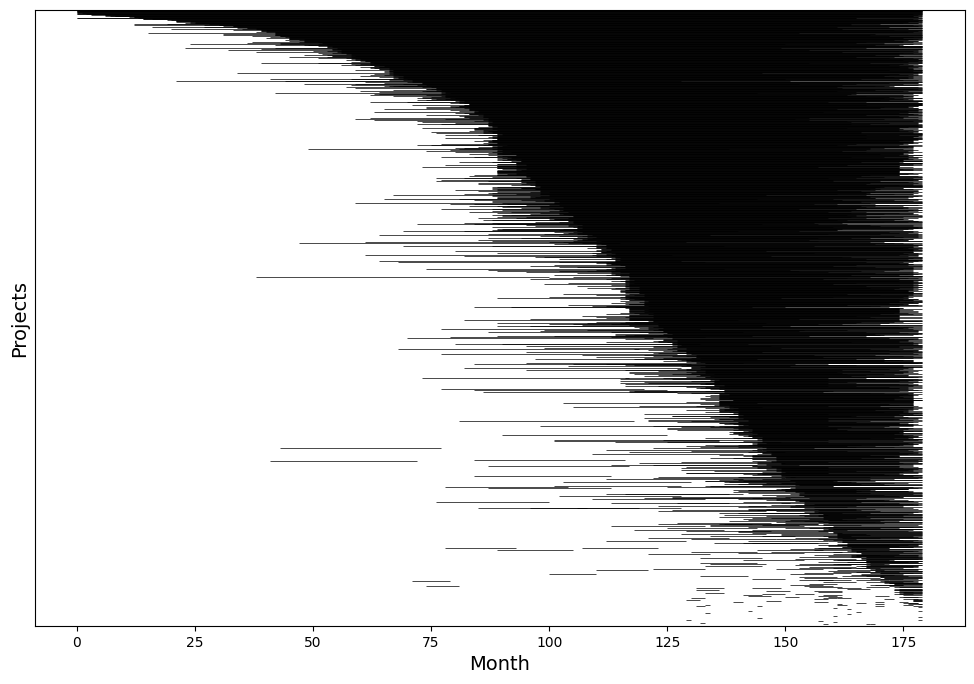

In [48]:
plt.rcParams["figure.figsize"]=[12,8]
plt.hlines(y=np.arange(graph_data.shape[0]), xmin=graph_data['start_month'], xmax=graph_data['end_month'], colors='black', linewidth=0.5)
plt.tick_params(left=False, labelleft=False)
plt.ylabel('Projects', fontsize=14)
plt.xlabel('Month', fontsize=14)
# plt.xlim((0, int((((ending_month - beginning_month)/np.timedelta64(1,'D'))/28))))
plt.ylim((0, graph_data.shape[0]))
plt.savefig('img/project_duration.pdf',bbox_inches='tight', dpi=150)